In [292]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# import required libraries for clustering
from sklearn.cluster import BisectingKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from fcmeans import FCM 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [293]:
lol = pd.read_csv('lol.csv')
# lol = lol[lol['Monetary'] <= 1500]
lol = lol[lol['Monetary'] >= 0000]
lol = lol[lol['Recency'] < 350]
# lol = lol[lol['Frequency'] <= 1000]
rfm = lol
lol.shape
# lol[lol['Frequency'] == 5]


(4158, 3)

Text(0.5, 0, 'Attributes')

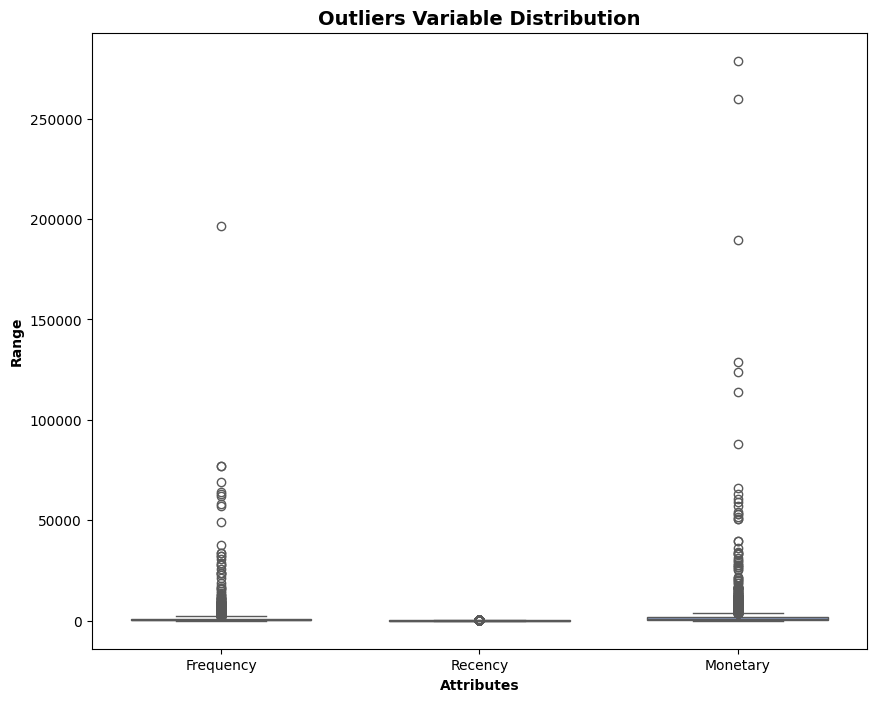

In [294]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Frequency','Recency','Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [295]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
# Q1 = rfm.Recency.quantile(0.05)
# Q3 = rfm.Recency.quantile(0.95)
# IQR = Q3 - Q1
# rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]
rfm.shape

(4088, 3)

In [296]:
# Rescaling the attributes

rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4088, 3)

In [297]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head(10)

,Monetary,Frequency,Recency
0,-0.747459,-0.751045,2.719079
1,1.696822,1.608346,-0.905668
2,0.067627,1.487401,-0.086453
3,0.079145,-0.146319,-0.726114
4,-0.580499,-0.562908,2.550747
5,-0.029821,-0.306619,-0.524116
6,-0.696985,-0.731847,1.361202
7,-0.135311,-0.242307,1.675421
8,-0.486925,-0.520673,1.473423
9,0.663209,0.758850,-0.681225


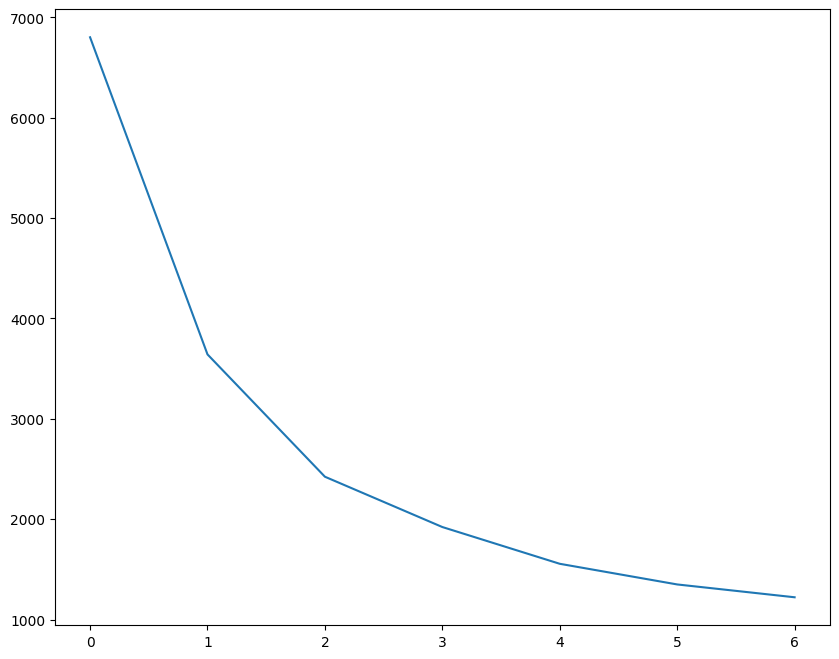

In [298]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init = 'random')
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [299]:
kmeans = KMeans(n_clusters=4, init="random")
start_time = time.time()
kmeans.fit(rfm_df_scaled)
end_time = time.time()
elapsed_time = end_time - start_time
rfm['Kmeans'] = kmeans.labels_
print("Time taken for fitting the Bisecting KMeans model:", elapsed_time, "seconds")
rfm.head()


Time taken for fitting the Bisecting KMeans model: 0.08198738098144531 seconds


,Recency,Frequency,Monetary,Kmeans
0,325,0,0.00,0
1,2,2458,4310.00,3
2,75,2332,1437.24,3
3,18,630,1457.55,2
4,310,196,294.40,0


In [300]:
fcm = FCM(n_clusters=4)

fcm.fit(rfm_df_scaled.to_numpy())
Fuzzy_c = fcm.predict(rfm_df_scaled.to_numpy())
rfm['Fuzzy_c'] = Fuzzy_c
rfm

,Recency,Frequency,Monetary,Kmeans,Fuzzy_c
0,325,0,0.00,0,3
1,2,2458,4310.00,3,2
2,75,2332,1437.24,3,2
3,18,630,1457.55,2,1
4,310,196,294.40,0,3
...,...,...,...,...,...
4277,277,45,180.60,0,3
4278,180,54,80.82,0,3
4279,7,98,176.60,2,1
4280,3,1355,2039.58,3,2


In [301]:
k=4
rfm_sorted = np.sort(rfm_df_scaled, axis=0)  # Sort each column (R, F, M)

  # Step 3: Calculate segment size
n, _ = rfm_df_scaled.shape
segment_size = n // k

  # Step 4: Initialize centroids with medians
centroids = np.zeros((k,3))
for i in range(k):
    segment_start = i * segment_size
    segment_end = segment_start + segment_size
    segment_data = rfm_sorted[segment_start:segment_end]
    centroids[i] = np.median(segment_data, axis=0)

RM_Kmeans = KMeans(n_clusters=4, init=centroids)
RM_Kmeans.fit(rfm_df_scaled)
rfm['RM_Kmeans'] = RM_Kmeans.labels_
rfm.head()

,Recency,Frequency,Monetary,Kmeans,Fuzzy_c,RM_Kmeans
0,325,0,0.00,0,3,2
1,2,2458,4310.00,3,2,1
2,75,2332,1437.24,3,2,1
3,18,630,1457.55,2,1,0
4,310,196,294.40,0,3,2


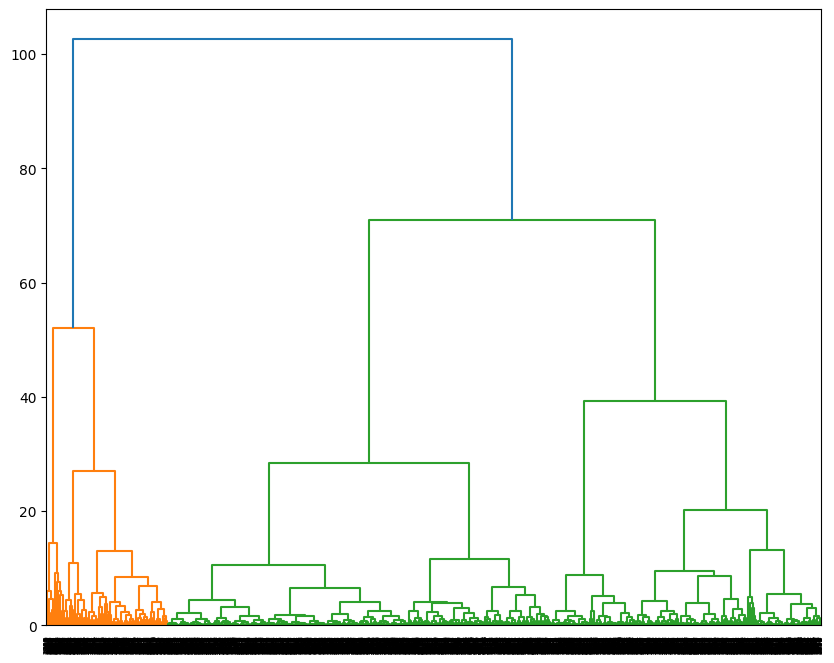

,Recency,Frequency,Monetary,Kmeans,Fuzzy_c,RM_Kmeans,Hierarchical
0,325,0,0.00,0,3,2,0
1,2,2458,4310.00,3,2,1,1
2,75,2332,1437.24,3,2,1,1
3,18,630,1457.55,2,1,0,2
4,310,196,294.40,0,3,2,0


In [302]:
# Ward linkage

mergings = linkage(rfm_df_scaled, method="ward", metric='euclidean')
dendrogram(mergings)
plt.show()

# Assign cluster labels
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
rfm['Hierarchical'] = cluster_labels
rfm.head()

In [303]:
band = estimate_bandwidth(rfm_df_scaled )
msc = MeanShift(bandwidth=band)

meanshft = msc.fit(rfm_df_scaled)
rfm['Mean_Shift'] = msc.labels_
len(rfm['Mean_Shift'].unique())

7

In [304]:
from sklearn.cluster import MiniBatchKMeans

def mini_batch_kmeans_with_labeling(rfm_df, scaled_rfm_df, n_clusters, mini_batch_size, max_iter):
    """
    Implements mini-batch k-means clustering on the scaled RFM data and adds cluster labels to the original RFM DataFrame.

    Args:
        rfm_df (pandas.DataFrame): The original RFM DataFrame containing Recency, Frequency, and Monetary data.
        scaled_rfm_df (pandas.DataFrame): The scaled RFM DataFrame.
        n_clusters (int): The number of desired clusters.
        mini_batch_size (int): The size of the mini-batches.
        max_iter (int): The maximum number of iterations for the k-means algorithm.

    Returns:
        pandas.DataFrame: The original RFM DataFrame with an added column named 'cluster' containing the cluster labels.
    """

    # Create a MiniBatchKMeans object
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)

    # Train the model using partial_fit for each mini-batch
    for _ in range(max_iter):
        # Shuffle data for each iteration (optional, to avoid biases)
        shuffled_indices = np.random.permutation(len(scaled_rfm_df))
        scaled_rfm = scaled_rfm_df.iloc[shuffled_indices].reset_index(drop=True)

        # Iterate over mini-batches
        for i in range(0, len(scaled_rfm), mini_batch_size):
            mini_batch = scaled_rfm.iloc[i:i+mini_batch_size]
            model.partial_fit(mini_batch)

    # Predict cluster labels for all scaled data points
    cluster_labels = model.predict(scaled_rfm_df)

    # Add cluster labels to the original RFM DataFrame
    rfm_df['Incremental'] = cluster_labels

    return rfm_df

# Assuming you have your RFM data in a DataFrame named 'rfm_df'
# Example usage:
n_clusters = 4  # Replace with the desired number of clusters
mini_batch_size = 100
max_iter = 100

# Create a StandardScaler object for scaling (replace with your scaling method if needed
scaled_rfm_df = rfm_df_scaled
# Apply mini-batch k-means and add cluster labels
rfm_df_with_clusters = mini_batch_kmeans_with_labeling(rfm.copy(), scaled_rfm_df, n_clusters, mini_batch_size, max_iter)
rfm = rfm_df_with_clusters
print(rfm_df_with_clusters)  # Output the RFM DataFrame with the added 'cluster' column


      Recency  Frequency  Monetary  Kmeans  Fuzzy_c  RM_Kmeans  Hierarchical  \
0         325          0      0.00       0        3          2             0   
1           2       2458   4310.00       3        2          1             1   
2          75       2332   1437.24       3        2          1             1   
3          18        630   1457.55       2        1          0             2   
4         310        196    294.40       0        3          2             0   
...       ...        ...       ...     ...      ...        ...           ...   
4277      277         45    180.60       0        3          2             0   
4278      180         54     80.82       0        3          2             0   
4279        7         98    176.60       2        1          0             2   
4280        3       1355   2039.58       3        2          1             2   
4281       42       1586   1837.28       3        2          1             1   

      Mean_Shift  Incremental  
0      

In [305]:
bise = BisectingKMeans(n_clusters=4,  init='random')
start_time = time.time()
bise.fit(rfm_df_scaled)
end_time = time.time()
elapsed_time = end_time - start_time
rfm['B_kmeans'] = bise.labels_
print("Time taken for fitting the Bisecting KMeans model:", elapsed_time, "seconds")
# print("sil ===",silhouette_score(rfm_df_scaled,B_kmeans))
# print("cal===",calinski_harabasz_score(rfm_df_scaled,B_kmeans))
# print("dav===",davies_bouldin_score(rfm_df_scaled,B_kmeans))

Time taken for fitting the Bisecting KMeans model: 0.019994735717773438 seconds


In [306]:
print("Clustering Kmeans             ",silhouette_score(rfm_df_scaled,rfm['Kmeans']) )
print("Clustering Fuzzy C means      ",silhouette_score(rfm_df_scaled,rfm['Fuzzy_c']) )
print("Clustering RM_Kmeans          ",silhouette_score(rfm_df_scaled,rfm['RM_Kmeans']) )
print("Clustering Hierarchical       ",silhouette_score(rfm_df_scaled,rfm['Hierarchical']) )
print("Clustering Incremental Kmeans ",silhouette_score(rfm_df_scaled,rfm['Incremental']) )
print("Clustering Mean Shift         ",silhouette_score(rfm_df_scaled,rfm['Mean_Shift']) )
print("Clustering Bisecting K-Means  ",silhouette_score(rfm_df_scaled,rfm['B_kmeans']) )

Clustering Kmeans              0.5212525809537533
Clustering Fuzzy C means       0.513237233471598
Clustering RM_Kmeans           0.5212525809537533
Clustering Hierarchical        0.4326489448715264
Clustering Incremental Kmeans  0.5159825818537168
Clustering Mean Shift          0.49719689626182867
Clustering Bisecting K-Means   0.5340298326568068


In [307]:
print("Clustering Kmeans             ",davies_bouldin_score(rfm_df_scaled,rfm['Kmeans']) )
print("Clustering Fuzzy C means      ",davies_bouldin_score(rfm_df_scaled,rfm['Fuzzy_c']) )
print("Clustering RM_Kmeans          ",davies_bouldin_score(rfm_df_scaled,rfm['RM_Kmeans']) )
print("Clustering Hierarchical       ",davies_bouldin_score(rfm_df_scaled,rfm['Hierarchical']) )
print("Clustering Incremental Kmeans ",davies_bouldin_score(rfm_df_scaled,rfm['Incremental']) )
print("Clustering Mean Shift         ",davies_bouldin_score(rfm_df_scaled,rfm['Mean_Shift']) )
print("Clustering Bisecting K-Means  ",davies_bouldin_score(rfm_df_scaled,rfm['B_kmeans']) )

Clustering Kmeans              0.681096357162858
Clustering Fuzzy C means       0.6892293823791262
Clustering RM_Kmeans           0.681096357162858
Clustering Hierarchical        0.7271494730289398
Clustering Incremental Kmeans  0.686863960221451
Clustering Mean Shift          1.22793370763853
Clustering Bisecting K-Means   0.6524552497389473


In [308]:
print("Clustering Kmeans             ",calinski_harabasz_score(rfm_df_scaled,rfm['Kmeans']) )
print("Clustering Fuzzy C means      ",calinski_harabasz_score(rfm_df_scaled,rfm['Fuzzy_c']) )
print("Clustering RM_Kmeans          ",calinski_harabasz_score(rfm_df_scaled,rfm['RM_Kmeans']) )
print("Clustering Hierarchical       ",calinski_harabasz_score(rfm_df_scaled,rfm['Hierarchical']) )
print("Clustering Incremental Kmeans ",calinski_harabasz_score(rfm_df_scaled,rfm['Incremental']) )
print("Clustering Mean Shift         ",calinski_harabasz_score(rfm_df_scaled,rfm['Mean_Shift']) )
print("Clustering Bisecting K-Means  ",calinski_harabasz_score(rfm_df_scaled,rfm['B_kmeans']) )

Clustering Kmeans              5527.101954174292
Clustering Fuzzy C means       5502.302042779519
Clustering RM_Kmeans           5527.10195417429
Clustering Hierarchical        3987.1721343338863
Clustering Incremental Kmeans  5513.510739362005
Clustering Mean Shift          599.9682912158397
Clustering Bisecting K-Means   4915.070382863223


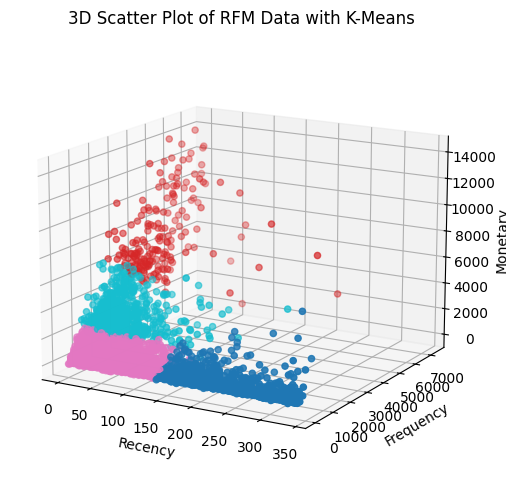

In [316]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extract data for the 3D plot (replace with desired features)
x = rfm["Recency"]
y = rfm["Frequency"]
z = rfm["Monetary"]
colors = rfm["Kmeans"]  # Use DBS_clustering for color mapping

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
ax.scatter(x, y, z, c=colors, cmap="tab10")

# Add labels and title
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Scatter Plot of RFM Data with K-Means")

# Rotate the plot for better visualization
ax.view_init(elev=15, azim=-60)

# Show the plot
plt.show()

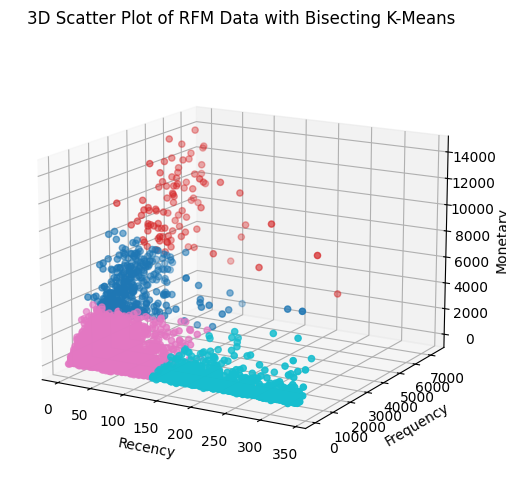

In [318]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extract data for the 3D plot (replace with desired features)
x = rfm["Recency"]
y = rfm["Frequency"]
z = rfm["Monetary"]
colors = rfm["B_kmeans"]  # Use DBS_clustering for color mapping

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
ax.scatter(x, y, z, c=colors, cmap="tab10")

# Add labels and title
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Scatter Plot of RFM Data with Bisecting K-Means")

# Rotate the plot for better visualization
ax.view_init(elev=15, azim=-60)

# Show the plot
plt.show()

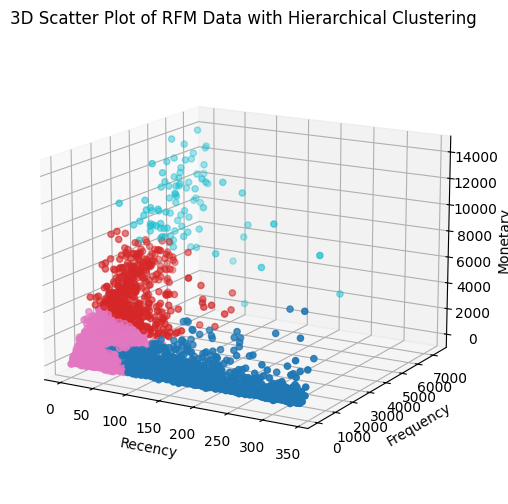

In [317]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Extract data for the 3D plot (replace with desired features)
x = rfm["Recency"]
y = rfm["Frequency"]
z = rfm["Monetary"]
colors = rfm["Hierarchical"]  # Use DBS_clustering for color mapping

# Create the 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
ax.scatter(x, y, z, c=colors, cmap="tab10")

# Add labels and title
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Scatter Plot of RFM Data with Hierarchical Clustering")

# Rotate the plot for better visualization
ax.view_init(elev=15, azim=-60)

# Show the plot
plt.show()

Overall silhouette score: 0.5212525809537533


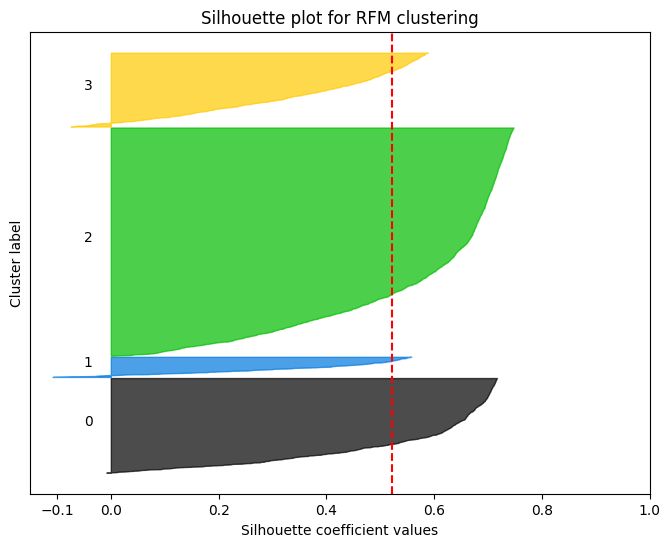

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming you have scaled RFM data in scaled_rfm_data and cluster labels in rfm['Kmeans']

# Compute the silhouette score for the entire dataset
silhouette_avg = silhouette_score(rfm_df_scaled, rfm['Kmeans'])
print("Overall silhouette score:", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(rfm_df_scaled, rfm['Kmeans'])

# Plotting the silhouette plot
plt.figure(figsize=(8, 6))
plt.title("Silhouette plot for RFM clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")

y_lower = 10
for i in np.unique(rfm['Kmeans']):
    ith_cluster_silhouette_values = sample_silhouette_values[rfm['Kmeans'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(rfm['Kmeans'])))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


Overall silhouette score: 0.5340298326568068


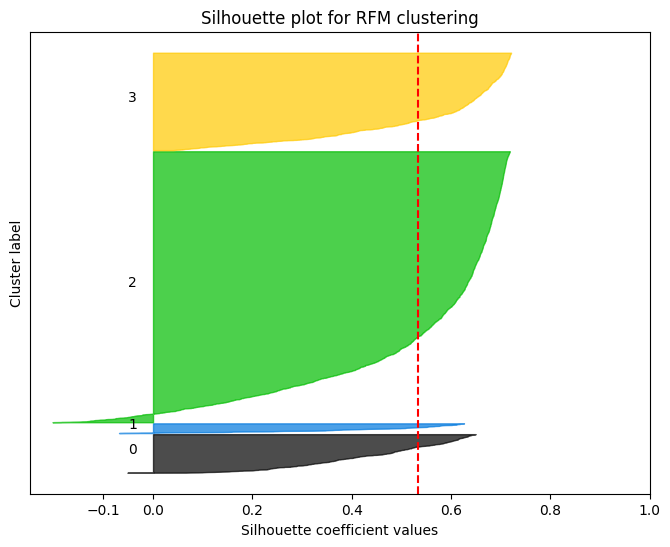

In [312]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming you have scaled RFM data in scaled_rfm_data and cluster labels in rfm['Kmeans']

# Compute the silhouette score for the entire dataset
silhouette_avg = silhouette_score(rfm_df_scaled, rfm['B_kmeans'])
print("Overall silhouette score:", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(rfm_df_scaled, rfm['B_kmeans'])

# Plotting the silhouette plot
plt.figure(figsize=(8, 6))
plt.title("Silhouette plot for RFM clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")

y_lower = 10
for i in np.unique(rfm['B_kmeans']):
    ith_cluster_silhouette_values = sample_silhouette_values[rfm['B_kmeans'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(rfm['B_kmeans'])))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


Overall silhouette score: 0.4326489448715264


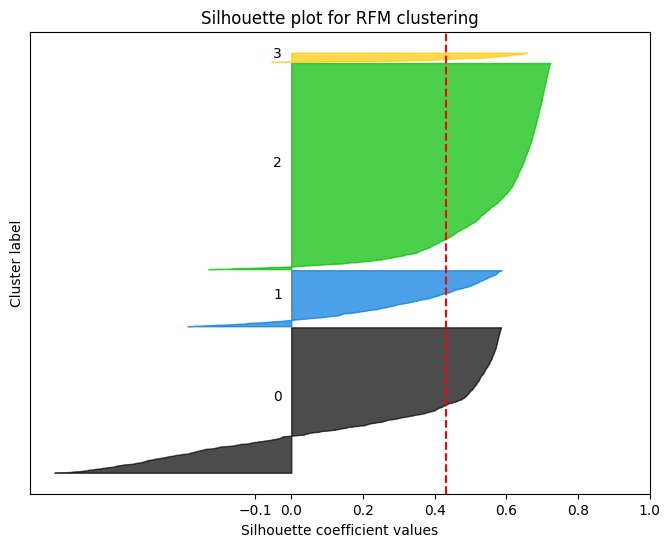

In [313]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Assuming you have scaled RFM data in scaled_rfm_data and cluster labels in rfm['Kmeans']

# Compute the silhouette score for the entire dataset
silhouette_avg = silhouette_score(rfm_df_scaled, rfm['Hierarchical'])
print("Overall silhouette score:", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(rfm_df_scaled, rfm['Hierarchical'])

# Plotting the silhouette plot
plt.figure(figsize=(8, 6))
plt.title("Silhouette plot for RFM clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")

y_lower = 10
for i in np.unique(rfm['B_kmeans']):
    ith_cluster_silhouette_values = sample_silhouette_values[rfm['Hierarchical'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(rfm['Hierarchical'])))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


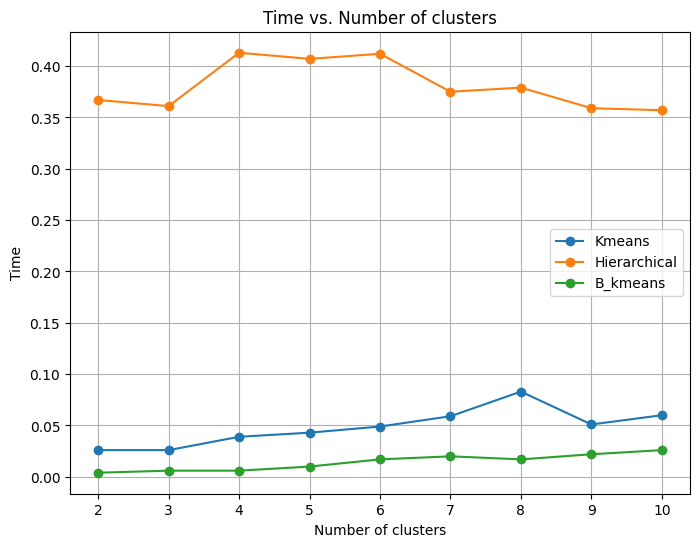

In [334]:
# Range of clusters to try
range_n_clusters = range(2, 11)
davies_bouldin_scores = []
d_h = []
d_B = []

for n_clusters in range_n_clusters:
    # Initialize KMeans with n_clusters and fit to the data
    kmeans = KMeans(n_clusters=n_clusters, init='random')
    start_time = time.time()
    cluster_labels = kmeans.fit_predict(rfm_df_scaled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(rfm_df_scaled, cluster_labels)
    davies_bouldin_scores.append(elapsed_time)
    
     # Initialize KMeans with n_clusters and fit to the data
    start_time = time.time()
    cluster_labels = cut_tree(mergings, n_clusters=n_clusters).reshape(-1, )
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(rfm_df_scaled, cluster_labels)
    d_h.append(elapsed_time)

    means = BisectingKMeans(n_clusters=n_clusters,  init='random')
    start_time = time.time()
    cluster_labels = means.fit_predict(rfm_df_scaled)
    end_time = time.time()
    elapsed_time = end_time - start_time
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(rfm_df_scaled, cluster_labels)
    d_B.append(elapsed_time)
    
# Plotting the Davies-Bouldin score vs. number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, davies_bouldin_scores, marker='o', label='Kmeans')
plt.plot(range_n_clusters, d_h, marker='o', label='Hierarchical')
plt.plot(range_n_clusters, d_B, marker='o', label='B_kmeans')
plt.title('Time vs. Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Time')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.legend()
plt.show()


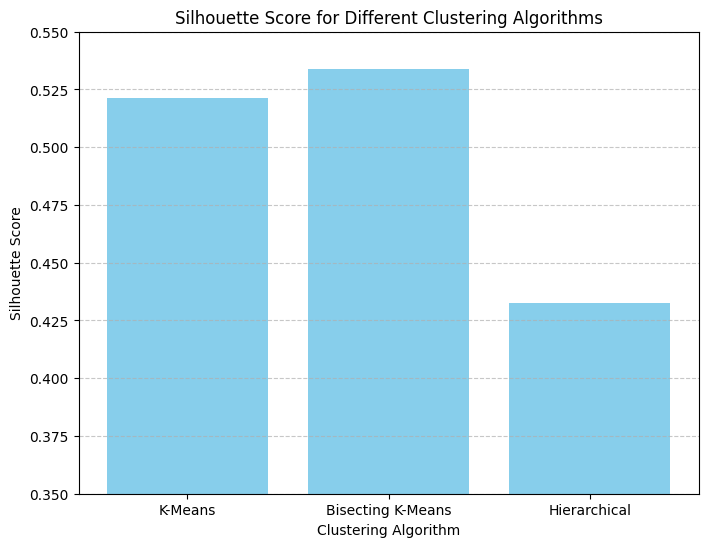

In [331]:
xyz = [silhouette_score(rfm_df_scaled,rfm['Kmeans']),silhouette_score(rfm_df_scaled,rfm['B_kmeans']),silhouette_score(rfm_df_scaled,rfm['Hierarchical'])]
zxy = ["K-Means", "Bisecting K-Means", "Hierarchical" ]
plt.figure(figsize=(8, 6))
plt.bar(zxy, xyz, color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Clustering Algorithms')
plt.ylim(0.35, 0.55)  # Optional: Set y-axis limits if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid lines
plt.show()

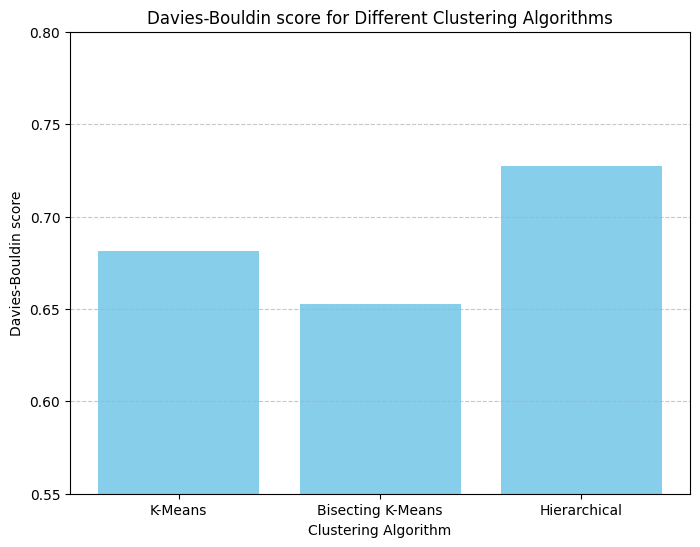

In [330]:
xyz = [davies_bouldin_score(rfm_df_scaled,rfm['Kmeans']),davies_bouldin_score(rfm_df_scaled,rfm['B_kmeans']),davies_bouldin_score(rfm_df_scaled,rfm['Hierarchical'])]
zxy = ["K-Means", "Bisecting K-Means", "Hierarchical" ]
plt.figure(figsize=(8, 6))
plt.bar(zxy, xyz, color='skyblue')
plt.xlabel('Clustering Algorithm')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin score for Different Clustering Algorithms')
plt.ylim(0.55, 0.8)  # Optional: Set y-axis limits if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid lines
plt.show()